# Chapter 2: Training simple machine learning algorithms for classification
___
The first of a series of notebooks following the exercises outlined in Python Machine Learning (Second Edition), by Sebastian Raschka & Vahid Mirjalili.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Part 1: Simple perceptron classification

In [2]:
# load in part of the Iris dataset from the UCI Machine Learning Repository
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases/iris/iris.data',
                 header=None)
# take the subset we're interested in (setosa & versicolor)
df_subset = df.iloc[0:100,:]
df_subset.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# select setosa and versicolor labels and convert to {-1,1}
y = df_subset[4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length + petal length features
X = df_subset[[0,2]].values

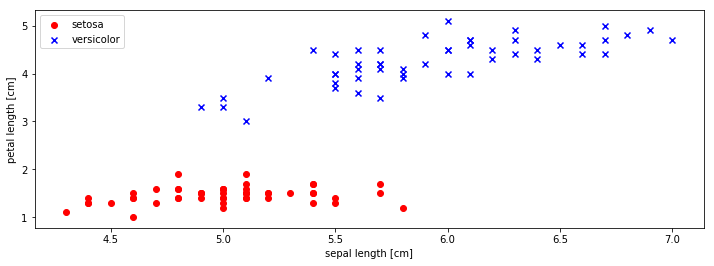

In [4]:
# plot data
plt.figure(figsize=(12, 4))
plt.scatter(X[:50,0], X[:50,1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:,0], X[50:,1],
            color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

### In this 2D subspace, it's clear that a linear boundry should be able to separate setosa vs. versicolor
So a linear classifier like a perceptron should work perfectly

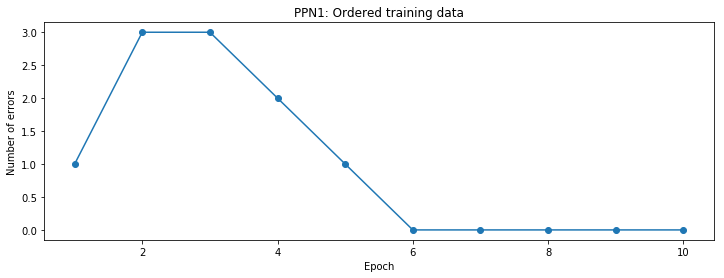

In [5]:
from models import Perceptron

# train the Perceptron
ppn1 = Perceptron(eta=0.1, n_iter=10)
ppn1.fit(X,y)

# plot the error
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(ppn1.errors_) + 1), 
         ppn1.errors_, marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Number of errors')
plt.title('PPN1: Ordered training data')
plt.show()

So we converge after the sixth epoch. Let's look at the decision boundary that we learned:

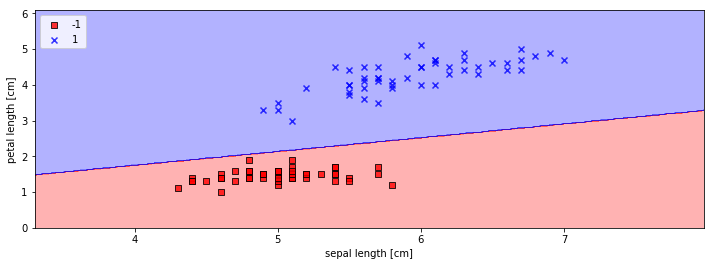

In [6]:
from extra import plot_decision_regions
plt.figure(figsize=(12, 4))
plot_decision_regions(X, y, classifier=ppn1)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

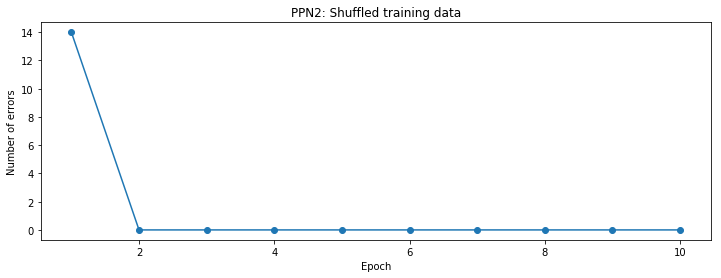

In [7]:
# if we shuffle the data do we get the same behavior?
df_subset_shuf = df_subset.sample(frac=1)
y_shuf = df_subset_shuf[4].values
y_shuf = np.where(y_shuf == 'Iris-setosa', -1, 1)
X_shuf = df_subset_shuf[[0,2]].values

ppn2 = Perceptron(eta=0.1, n_iter=10)
ppn2.fit(X_shuf,y_shuf)

# plot the error
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(ppn2.errors_) + 1), 
         ppn2.errors_, marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Number of errors')
plt.title('PPN2: Shuffled training data')
plt.show()

So we see that the order of the training data does matter here for rate of convergence. But the decision boundary looks similar:

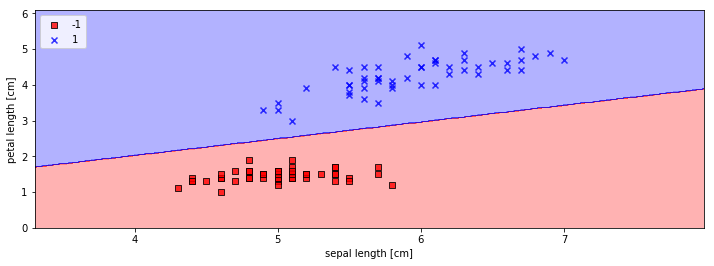

In [8]:
plt.figure(figsize=(12, 4))
plot_decision_regions(X_shuf, y_shuf, classifier=ppn2)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

Let's compare the weight vectors each model learned

In [9]:
print('PPN1 wieghts:', ppn1.w_)
print('PPN2 wieghts:', ppn2.w_)

PPN1 wieghts: [-0.38375655 -0.70611756  1.83471828]
PPN2 wieghts: [-0.38375655 -1.16611756  2.49471828]


The biggest issue with the Perceptron model is convergence. Convergence is only guaranteed if the two classes are separable by a linear hyperplane. If they are not, during training the weights will keep updating indefinitely unless we specify an error threshold or a maximum number of epochs.

___
## Part 2: Adaptive linear neurons (Adaline)

The main difference between the simple perceptron and Adaline is how the error is calculated and how it is used to update the weights. In the perceptron, the error is defined as the difference between the predicted class label and the true class label. In Adaline, we compare the true class labels with the linear activation function's continuous-valued output to compute the model error:

$$\phi(z) = \phi(w^Tx) = w^Tx$$

The cost function *J*, which is minimized to learn the weights, is defined as the **Sum of Squared Errors** between the calculated outcome and the true class label:

$$J(w) = \frac{1}{2} \sum_{i} \Big( y^{(i)} - \phi(z^{(i)})\Big)^{2}$$

The main advantage of the linear activation function (as opposed to the step function of the perceptron), is that the cost function becomes **differentiable**. It is also **convex**, meaning we can use gradient descent to find the global optimum. With each step, we update the weight vector using the gradient of the cost function:

$$\Delta w = -\eta \nabla J(w)$$

$$\Delta w_j = -\eta \frac{\delta J}{\delta w_j} = -\eta \frac{1}{2} \frac{\delta}{\delta w_j} \sum_{i} \Big( y^{(i)} - \phi(z^{(i)})\Big)^{2} = \eta \sum_{i} \Big( y^{(i)} - \phi(z^{(i)})\Big)x^{(i)}_j$$

So each weight $w_j$ is adjusted according the **sum** of the differences between the true labels and the activation values for **all samples**, each one weighted by the value of the $j$th feature of that sample. Weight updates are thus performed after all samples have been predicted, which is why this appraoch is called **batch gradient descent**.

We'll test two different learning rates and see how Adaline does on the Iris dataset:

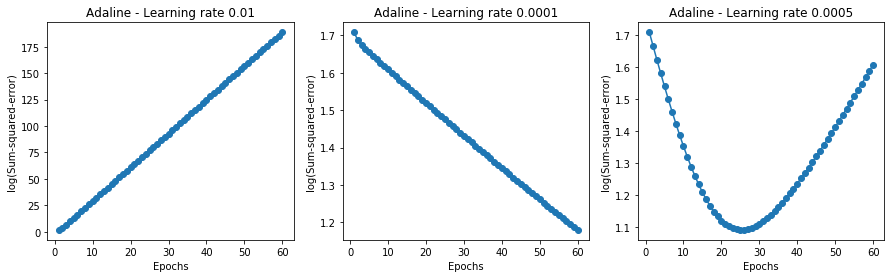

In [42]:
from models import AdalineGD

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

# LARGE learning rate
ada1 = AdalineGD(n_iter=60, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) +1),
           np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

# SMALL learning rate
ada2 = AdalineGD(n_iter=60, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) +1),
           np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')

# MEDIUM learning rate
ada3 = AdalineGD(n_iter=60, eta=0.0005).fit(X, y)
ax[2].plot(range(1, len(ada3.cost_) +1),
           np.log10(ada3.cost_), marker='o')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('log(Sum-squared-error)')
ax[2].set_title('Adaline - Learning rate 0.0005')

plt.show()

### The charts above illustrate how the learning rate can influence model training and performance.